In [1]:
from sena.data.norec.dataloader import load_full_dataset
import sena.utils.preprocessing as preprocessing
import pandas as pd

In [2]:
# Loading data
data = load_full_dataset()

train = data["train"]
val = data["dev"]
test = data["test"]

# Shuffling data
train = train.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

# Cleaning values in the text column
train = preprocessing.clean_text(train, "text")
val = preprocessing.clean_text(val, "text")
test = preprocessing.clean_text(test, "text")

# Combining data for later use
combined_data = pd.concat([train, val, test]).reset_index(drop=True)
combined_data = preprocessing.clean_text(combined_data, "text")

Loading multiclass dev data: 100%|██████████| 4360/4360 [00:27<00:00, 158.36it/s]


In [3]:
train.head()

,text,label
0,windows movie maker vista gratis kommer ferdig...,1
1,sølvkantet gjenforening grusom lyd vill energi...,1
2,canon pixma mg overbevisende fotokvalitet lynr...,2
3,boy striped pyjamas beste intensjoner prestasj...,1
4,xl playground sikker virkelig trenger kvintett...,1


In [4]:
from collections import Counter
import math

num_words = Counter()
for review in combined_data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

# Deciding the vocabulary size
num_words = len(num_words) / 20
num_words = math.ceil(num_words / 1000) * 1000
print("Number of words:", num_words)

Number of words: 26000


In [5]:
average_text_length = combined_data["text"].str.len().mean()
max_text_length = combined_data["text"].str.len().max()

print("Average text length:", int(average_text_length))
print("Max text length:", int(max_text_length))

Average text length: 1623
Max text length: 14505


In [6]:
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import numpy as np

# Separating texts and labels
X_train, y_train = train["text"], train["label"]
X_val, y_val = val["text"], val["label"]
X_test, y_test = test["text"], test["label"]

# Fitting a tokenizer to text from the combined data
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(combined_data["text"].tolist())

# Converting texts to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [7]:
# Deciding embedding vector length
maxlen = (int(np.ceil(np.mean([len(text.split()) for text in combined_data.text]))))

# Padding sequences with zeros until they reach a certain length
X_train = pad_sequences(X_train, maxlen=maxlen, padding="post", truncating="post")
X_val = pad_sequences(X_val, maxlen=maxlen, padding="post", truncating="post")
X_test = pad_sequences(X_test, maxlen=maxlen, padding="post", truncating="post")

In [8]:
num_classes = len(np.unique(y_train))
print("Number of classes:", num_classes)

# One-hot encoding of labels
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

Number of classes: 3


In [9]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape, end="\n\n")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape, end="\n\n")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (34903, 204)
y_train shape: (34903, 3)

X_val shape: (4360, 204)
y_val shape: (4360, 3)

X_test shape: (4351, 204)
y_test shape: (4351, 3)


In [10]:
import itertools

# 10 most common words in the vocabulary
dict(itertools.islice(tokenizer.word_index.items(), 10))

{'<OOV>': 1,
 'litt': 2,
 'får': 3,
 'gjør': 4,
 'helt': 5,
 'godt': 6,
 'filmen': 7,
 'år': 8,
 'alt': 9,
 'nok': 10}

In [11]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional

model = Sequential()
model.add(Embedding(num_words, 64))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

In [12]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1664000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,730,435
Trainable params: 1,730,435
Non-trainable params: 0
_________________________________________________________________


In [13]:
from keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor="val_accuracy", patience=3)]

epochs = 20
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1,
                    callbacks=callbacks)

Epoch 1/20
1091/1091 [==============================] - 151s 134ms/step - loss: 0.8109 - accuracy: 0.6025 - val_loss: 0.8606 - val_accuracy: 0.5195
Epoch 2/20
1091/1091 [==============================] - 140s 128ms/step - loss: 0.6009 - accuracy: 0.7390 - val_loss: 0.7205 - val_accuracy: 0.6670
Epoch 3/20
1091/1091 [==============================] - 140s 128ms/step - loss: 0.3919 - accuracy: 0.8421 - val_loss: 0.8490 - val_accuracy: 0.6633
Epoch 4/20
1091/1091 [==============================] - 143s 131ms/step - loss: 0.2182 - accuracy: 0.9211 - val_loss: 1.0941 - val_accuracy: 0.6495
Epoch 5/20
1091/1091 [==============================] - 143s 131ms/step - loss: 0.1151 - accuracy: 0.9606 - val_loss: 1.4448 - val_accuracy: 0.6353


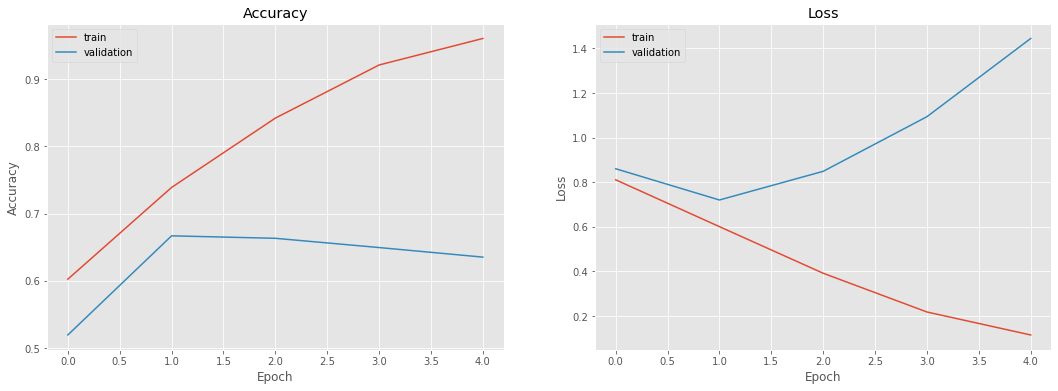

In [14]:
from sena.utils.visualization import plot_history

plot_history(history)

In [15]:
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=1)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

136/136 [==============================] - 5s 39ms/step - loss: 1.4147 - accuracy: 0.6444
Validation loss: 1.4147138595581055
Validation accuracy: 0.6444495320320129


In [16]:
from datetime import datetime

if val_acc > 0.8:
    model.save(f"models/SA-LSTM-MULTICLASS-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")